### Azure Facial Recognition

- Create and use a custom model to perform facial recognition of a specific person. 

##### Required Python modules/SDKs

In [1]:
import datetime
import pandas as pd
from PIL import Image
import requests
import io
import glob, os, sys, time, uuid

from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt
%matplotlib inline

from urllib.parse import urlparse
from io import BytesIO
from PIL import Image, ImageDraw

from azure.cognitiveservices.vision.face import FaceClient
from azure.cognitiveservices.vision.face.models import TrainingStatusType
from msrest.authentication import CognitiveServicesCredentials

##### Accessing Specific Azure Resources

In [2]:
FACE_SERV_KEY = "1d4f70d496eb4e40aef496987ea87202"
FACE_SERV_ENDPOINT = "https://faceservicefacialrecog.cognitiveservices.azure.com/"

In [3]:
# Create a client
face_client = FaceClient(FACE_SERV_ENDPOINT, CognitiveServicesCredentials(FACE_SERV_KEY))
face_client.api_version

'1.0'

##### Upload And View Images

In [4]:
!ls mo*.jpg

mo10.jpg  mo2.jpg  mo4.jpg  mo6.jpg  mo8.jpg
mo1.jpg   mo3.jpg  mo5.jpg  mo7.jpg  mo9.jpg


In [5]:
# Get a list of images with file name starting with "human-face"
my_face_images = [file for file in glob.glob('*.jpg') if file.startswith("mo")]
print(my_face_images)

['mo5.jpg', 'mo9.jpg', 'mo1.jpg', 'mo4.jpg', 'mo7.jpg', 'mo2.jpg', 'mo10.jpg', 'mo6.jpg', 'mo8.jpg', 'mo3.jpg']


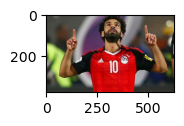

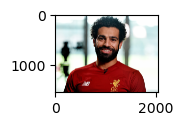

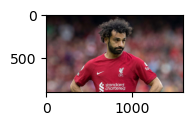

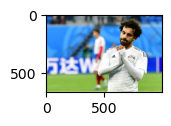

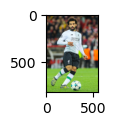

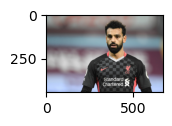

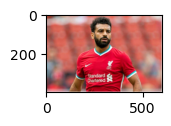

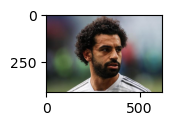

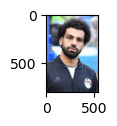

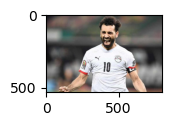

In [6]:
# Plot the images
for img in my_face_images:
    with open(img, 'rb') as img_code:
        img_view_ready = Image.open(img_code)
        plt.figure(figsize=(2,1))
        plt.imshow(img_view_ready)

##### Creating Person Model

In [7]:
PERSON_GROUP_ID = str(uuid.uuid4())
person_group_name = 'mohammad-salah'

In [8]:
# Todo: define a function to create and train a person group
def build_person_group(client, person_group_id, pgp_name):
    print('Create and build a person group...')
    # Create empty Person Group. Person Group ID must be lower case, alphanumeric, and/or with '-', '_'.
    print('Person group ID:', person_group_id)
    
    # Todo: create a person group using the person_group.create object
    client.person_group.create(person_group_id = person_group_id, name=person_group_id)

    # Todo: create a person group person using the person_group_person.create object
    my_face = client.person_group_person.create(person_group_id, pgp_name)
    
    # Find all jpeg images of human in working directory.
    my_face_images = [file for file in glob.glob('*.jpg') if file.startswith("mo")]
    
    # Add images to a Person object
    for image_p in my_face_images:
        with open(image_p, 'rb') as w:
            client.person_group_person.add_face_from_stream(person_group_id, my_face.person_id, w)

    # Todo: train the person group using the person_group.train object
    client.person_group.train(person_group_id)
    

    # Wait for training to finish.
    while (True):
        training_status = client.person_group.get_training_status(person_group_id)
        print("Training status: {}.".format(training_status.status))
        if (training_status.status is TrainingStatusType.succeeded):
            break
        elif (training_status.status is TrainingStatusType.failed):
            client.person_group.delete(person_group_id=PERSON_GROUP_ID)
            sys.exit('Training the person group has failed.')
        time.sleep(5)

In [9]:
build_person_group(face_client, PERSON_GROUP_ID, person_group_name)

Create and build a person group...
Person group ID: 672eb282-e08b-4c92-8bfa-76a1b61b870b
Training status: running.
Training status: succeeded.


##### Making Sure The Faces In The Person Model Belong To The Same Person

In [10]:
# Todo: detect all faces in query_image_list, then add their face IDs to a new list.
def detect_faces(client, query_images_list):
    print('Detecting faces in query images list...')

    face_ids = {} # Keep track of the image ID and the related image in a dictionary
    for image_name in query_images_list:
        image = open(image_name, 'rb') # BufferedReader
        print("Opening image: ", image.name)
        time.sleep(5)

        # Todo: detect the faces in the query images list using face.detect_with_stream object
        faces = face_client.face.detect_with_stream(image)

        # Add all detected face IDs to a list
        for face in faces:
            print('Face ID', face.face_id, 'found in image', os.path.splitext(image.name)[0]+'.jpg')
            # Add the ID to a dictionary with image name as a key.
            # This assumes there is only one face per image (since you can't have duplicate keys)
            face_ids[image.name] = face.face_id

    return face_ids

In [11]:
# Detect faces in the test images
ids = detect_faces(face_client, my_face_images)
ids

Detecting faces in query images list...
Opening image:  mo5.jpg
Face ID b55a190d-b3e1-4dc7-a889-0d79ccb87a6a found in image mo5.jpg
Opening image:  mo9.jpg
Face ID 448509ab-98ab-4311-b3dd-ed30f974cebc found in image mo9.jpg
Opening image:  mo1.jpg
Face ID 54aa7f52-e801-48ee-895a-a95cc94427da found in image mo1.jpg
Opening image:  mo4.jpg
Face ID c7f5d2c0-f921-42aa-8e69-99dd1470e077 found in image mo4.jpg
Opening image:  mo7.jpg
Face ID e8e54301-89e8-48b6-93ec-8505320d27ab found in image mo7.jpg
Opening image:  mo2.jpg
Face ID b5747ffa-1841-4cb8-9c0c-f6d3d8b29b96 found in image mo2.jpg
Opening image:  mo10.jpg
Face ID cfb3bd57-63ea-4fbf-ab07-7e2f87148549 found in image mo10.jpg
Opening image:  mo6.jpg
Face ID 09a4ee50-2366-4f73-b0e3-335f922ff364 found in image mo6.jpg
Opening image:  mo8.jpg
Face ID 97e822b5-46ee-46c1-b673-000b63aa84a1 found in image mo8.jpg
Opening image:  mo3.jpg
Face ID 849b9710-e0e9-4130-8ae0-a736ffa15cad found in image mo3.jpg


{'mo5.jpg': 'b55a190d-b3e1-4dc7-a889-0d79ccb87a6a',
 'mo9.jpg': '448509ab-98ab-4311-b3dd-ed30f974cebc',
 'mo1.jpg': '54aa7f52-e801-48ee-895a-a95cc94427da',
 'mo4.jpg': 'c7f5d2c0-f921-42aa-8e69-99dd1470e077',
 'mo7.jpg': 'e8e54301-89e8-48b6-93ec-8505320d27ab',
 'mo2.jpg': 'b5747ffa-1841-4cb8-9c0c-f6d3d8b29b96',
 'mo10.jpg': 'cfb3bd57-63ea-4fbf-ab07-7e2f87148549',
 'mo6.jpg': '09a4ee50-2366-4f73-b0e3-335f922ff364',
 'mo8.jpg': '97e822b5-46ee-46c1-b673-000b63aa84a1',
 'mo3.jpg': '849b9710-e0e9-4130-8ae0-a736ffa15cad'}

##### Verify that 2 random images from the list belong to the same person

In [12]:
# Todo: use face.verify_face_to_face object to verify that 2 random faces from the list belong to the same person
verify_result = face_client.face.verify_face_to_face(ids[my_face_images[0]], ids[my_face_images[6]])

In [13]:
if verify_result.is_identical:
    print("Faces are of the same (Positive) person, similarity confidence: {}.".format(verify_result.confidence))
else:
    print("Faces are of different (Negative) persons, similarity confidence: {}.".format(verify_result.confidence))

Faces are of the same (Positive) person, similarity confidence: 0.6562.


##### Prepare An Image For Facial Recognition

In [14]:
# Todo: Replace with your own image URL. This image will be used to perform facial recognition
dl_source_url = "https://www.soccerbible.com/media/131874/salah-2-min.jpg"

In [15]:
# Todo: detect the face in the image using face.detect_with_url object
dl_faces = face_client.face.detect_with_url(dl_source_url)

In [ ]:
## -------
## Reading file locally
## -------
# If you uploaded an image file locally, you should use the following method to detect the face
# dl_image = open('/your-local-file-system/udacity/cal-dl.png', 'rb')
# dl_faces = face_client.face.detect_with_stream(dl_image)  

In [16]:
# View Face ID and then save it into the list of already saved Face IDs
for face in dl_faces:
    print('Face ID', face.face_id, 'found in image', dl_source_url)
    # Add the ID to a dictionary with image name as a key.
    # This assumes there is only one face per image (since you can't have duplicate keys)
    ids['mo-from-url.jpg'] = face.face_id

Face ID d452c805-c2e5-484f-a3af-05a3cb7925de found in image https://www.soccerbible.com/media/131874/salah-2-min.jpg


In [17]:
# Now, you should have (n + 1) Face IDs in your Face ID list
ids

{'mo5.jpg': 'b55a190d-b3e1-4dc7-a889-0d79ccb87a6a',
 'mo9.jpg': '448509ab-98ab-4311-b3dd-ed30f974cebc',
 'mo1.jpg': '54aa7f52-e801-48ee-895a-a95cc94427da',
 'mo4.jpg': 'c7f5d2c0-f921-42aa-8e69-99dd1470e077',
 'mo7.jpg': 'e8e54301-89e8-48b6-93ec-8505320d27ab',
 'mo2.jpg': 'b5747ffa-1841-4cb8-9c0c-f6d3d8b29b96',
 'mo10.jpg': 'cfb3bd57-63ea-4fbf-ab07-7e2f87148549',
 'mo6.jpg': '09a4ee50-2366-4f73-b0e3-335f922ff364',
 'mo8.jpg': '97e822b5-46ee-46c1-b673-000b63aa84a1',
 'mo3.jpg': '849b9710-e0e9-4130-8ae0-a736ffa15cad',
 'mo-from-url.jpg': 'd452c805-c2e5-484f-a3af-05a3cb7925de'}

##### Perform Face Verification Between One Of The Face In The Person Model And The Sample Image Face

In [18]:
# Todo: use face.verify_face_to_face to verify that the faces belong to the same person.
# Make sure you verify between the sample image and one of the image in the person model
dl_verify_result = face_client.face.verify_face_to_face(ids[my_face_images[0]], ids['mo-from-url.jpg'])

In [19]:
if dl_verify_result.is_identical:
    print("Faces are of the same (Positive) person, similarity confidence: {}.".format(verify_result.confidence))
else:
    print("Faces are of different (Negative) persons, similarity confidence: {}.".format(verify_result.confidence))

Faces are of the same (Positive) person, similarity confidence: 0.6562.


In [20]:
# Convert width height to a point in a rectangle
def getRectangle(faceDictionary):
    rect = faceDictionary.face_rectangle
    left = rect.left
    top = rect.top
    right = left + rect.width
    bottom = top + rect.height
    
    return ((left, top), (right, bottom))

# Draw boxes around every detected faces
def drawFaceRectangles(source_file, detected_face_object) :
    # Download the image from the url
    response = requests.get(source_file)
    img = Image.open(BytesIO(response.content))
    # Draw a red box around every detected faces
    draw = ImageDraw.Draw(img)
    for face in detected_face_object:
        draw.rectangle(getRectangle(face), outline='red', width = 10)
    return img

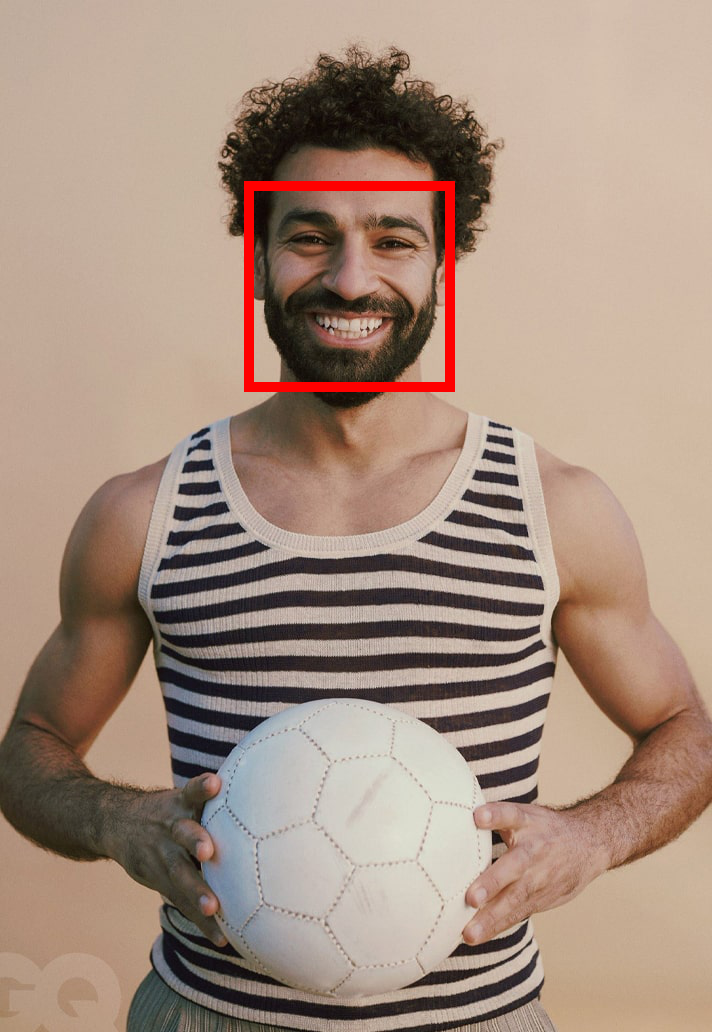

In [21]:
drawFaceRectangles(dl_source_url, dl_faces)

##### Identify The Sample Image with The Person Model 

In [22]:
# A list of Face ID
ids

{'mo5.jpg': 'b55a190d-b3e1-4dc7-a889-0d79ccb87a6a',
 'mo9.jpg': '448509ab-98ab-4311-b3dd-ed30f974cebc',
 'mo1.jpg': '54aa7f52-e801-48ee-895a-a95cc94427da',
 'mo4.jpg': 'c7f5d2c0-f921-42aa-8e69-99dd1470e077',
 'mo7.jpg': 'e8e54301-89e8-48b6-93ec-8505320d27ab',
 'mo2.jpg': 'b5747ffa-1841-4cb8-9c0c-f6d3d8b29b96',
 'mo10.jpg': 'cfb3bd57-63ea-4fbf-ab07-7e2f87148549',
 'mo6.jpg': '09a4ee50-2366-4f73-b0e3-335f922ff364',
 'mo8.jpg': '97e822b5-46ee-46c1-b673-000b63aa84a1',
 'mo3.jpg': '849b9710-e0e9-4130-8ae0-a736ffa15cad',
 'mo-from-url.jpg': 'd452c805-c2e5-484f-a3af-05a3cb7925de'}

In [23]:
# Todo: enter the face ID of the sample image
get_the_face_id_from_the_url = 'd452c805-c2e5-484f-a3af-05a3cb7925de'

In [24]:
# Todo: identify the sample image using the face.identify object
person_gp_results = face_client.face.identify([get_the_face_id_from_the_url], PERSON_GROUP_ID)

In [25]:
for result in person_gp_results:
    for candidate in result.candidates:
        print("The Identity match confidence is {}".format(candidate.confidence))

The Identity match confidence is 0.66474


### End